# Minibatch training, training our first actual model

## Setup

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])
     


## Data

In [3]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50 #This is the numenr of hidden layers
n, m, c, nh

(50000, 784, tensor(10), 50)

In [4]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers =[nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x



In [5]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

# Cross entropy loss

Here we are upgrading the loss function to cross entropy. So for this we use the softmax function: For this we take the exponential of the predictions and divide by the sum of all the exponentials. This give us a number between 0 and 1, to ease data analysis. The exponential also exaggerates differences between the numbers, to give more clease predictions. 

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [6]:
# Here we use the log of softmax

def log_softmax(x): return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

In [7]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

In [8]:
# Mathematically the following is equivalent but simplified

def log_softmax(x): return x - (x.exp().sum(-1, keepdim=True)).log()

In [9]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

Now the x could give us really large numbers, with their derivates. With the limits of floating point accuracy on computers, this can lead to disastrous computational inaccuracy. So we use the LogSumExp trick to reduce the numbers . It is mathematically derived as follows. We subtract the largest value of x from all of them (we call this a), giving us smaller numbers. Then we multiply with with e**a to give the same number

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [10]:
def logsumexp(x): 
    m = x.max(-1)[0]
    return m + (x - m[:,None]).exp().sum(-1).log()
    

In [11]:
# Our rewritten function
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [12]:
# Pytorch has already implemented this function, which we can call as follows and test it against our function, here we call it as a method of the tensor "pred"

test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [13]:
# Now we look at the first three actual targets
y_train[:3]

tensor([5, 0, 4])

In [14]:
# To look these up in our predictions
sm_pred[0,5], sm_pred[1,0], sm_pred[2, 4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [15]:
# An easier way to do this
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [16]:
# Implementing the function to calculate "negative log likelihood loss", Pytorch does this too

def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [17]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [18]:
# Pytorch implementation

test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In [19]:
# In Pytorch the softmax and NLL methods are combined in the crossentropy methods which can be called like this:

test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

# Basic training loop 

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [20]:
loss_func = F.cross_entropy

In [21]:
bs = 50

xb = x_train[:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [22]:
yb = y_train[:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [23]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [24]:
preds

tensor([[    -0.09,     -0.21,     -0.08,      0.10,     -0.04,      0.08,     -0.04,     -0.03,      0.01,      0.06],
        [    -0.07,     -0.14,     -0.14,     -0.03,     -0.00,      0.13,     -0.04,      0.03,      0.04,      0.14],
        [    -0.19,     -0.04,      0.02,      0.21,     -0.06,     -0.00,     -0.08,     -0.01,     -0.00,      0.02],
        [    -0.05,     -0.21,     -0.07,      0.08,      0.04,      0.08,     -0.10,     -0.01,      0.09,      0.01],
        [    -0.15,     -0.19,     -0.04,      0.06,     -0.05,      0.15,     -0.11,      0.01,      0.08,      0.05],
        [    -0.11,     -0.13,     -0.10,      0.00,     -0.05,      0.13,     -0.07,      0.03,      0.07,      0.17],
        [    -0.07,     -0.15,     -0.01,      0.10,     -0.05,     -0.03,     -0.08,     -0.02,     -0.00,      0.07],
        [    -0.05,     -0.20,     -0.01,      0.10,      0.02,      0.16,     -0.10,     -0.05,      0.05,      0.17],
        [    -0.11,     -0.17,     -0.04

In [25]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [26]:
def accuracy (out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [27]:
accuracy(preds, yb)

tensor(0.08)

In [28]:
lr = 0.5
epochs = 3

In [29]:
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')


In [30]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb,yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

0.12, 0.98
0.12, 0.94
0.08, 0.96


# Using paramaters and optimisation

## Parameters

In [31]:
# Demonstration of PyTorch inhertied module functionality

m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [32]:
# You can list children defined under m1, in this case "foo", in other cases all the layers of our neural network

list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [33]:
#But you have to say "list", as it is a kind of iterator, called a generator, that only gives an output if it is used
m1.named_children()

<generator object Module.named_children at 0x7f9f80292730>

In [34]:
# You can also list the parameters

list(m1.parameters())


[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [35]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [36]:
model = MLP(m, nh, 10)

In [37]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [38]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [39]:
for name,l in model.named_children(): print(f"{name}: {l}")


l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [40]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [41]:
# Refactoring the basic loop to use this functionality

def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)
        
# Pytorch uses __set__attr to know what the models parameters are so it can update them with the new weights
        

In [42]:
fit()

0.19, 0.96
0.11, 0.96
0.04, 1.00


In [43]:
# Now we create our own nn.Module

class MyModule: 
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
#         Creates a dictionary that keeps track of all the layers in our network
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k , v):        
#         k (key)is the name of the attribute, v (value) is right of the =, e.g. "nn.Linear(n_in, nh)"
#         We don't want to add the dunder methods to this list
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)    
#         As Python itself has the setattr functionality which can be called for the attribute-setting

#     Now the function where we called "model" in the code and it listed the layers
    def __repr__(self): return f'{self._modules}'
 
    # This, then is the method that prints all the parameter sizes of our model
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

In [44]:
mdl = MyModule(m, nh, 10)

In [45]:
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [46]:
mdl.parameters

<bound method MyModule.parameters of {'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}>

In [47]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## Registering modules

In [48]:
 from functools import reduce

In [49]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [50]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):  self.add_module(f'layer_{i}', l)

#     Here we create a forward pass using "reduce". This function uses input x, then iterates over the
#     the iterable "self.layers" to perform the layer function. "val" stores the intermediate values 
#     to be passed over to the next iterable 
    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)
                              
                             

In [51]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## Using ModuleList

In [52]:
 # Now Pytorch has the implemented method nn.ModuleList that does this for us
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
            
    
#     Here note the different implementation of the forward method compared to the above
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [53]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

## Using nn.Sequential

In [54]:
# Now that we've implemented the sequential model, we can use the PyTorch version

model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [55]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.16, 0.94
0.13, 0.96
0.08, 0.96


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

## Optim

In [56]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
            
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [57]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10))

In [58]:
opt = Optimizer(model.parameters())

In [59]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


In [60]:
# Now that we've implemented it, we can use Pytorch's optimiser, called optim

from torch import optim


In [61]:
# We use this function to return a model (using our previous architecture), as well as the optimser that it will use

def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [62]:
model, opt = get_model()
loss_func(model(xb), yb)

# We call this loss function now to check the loss before optimising with our model

tensor(2.33, grad_fn=<NllLossBackward0>)

In [63]:
# THe same loop as above, we are just using Pytorch optim instead of our own implementation

for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


# Dataset and dataloader


### Dataset

It's clunky to iterate through minibatches of x and y values separately:

xb = x_train[s]
    yb = y_train[s]
Instead, let's do these two steps together, by introducing a Dataset class:

xb,yb = train_ds[s]

In [64]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

# dunder len method allows us to get the length so we can check it, or use it in functions
# dunder getitem lets us pull out slices of the dataset
# This whole function puts the x_train and y_train into one dataset that we can the call to more conveniently 

In [65]:
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

# To check the methods in the function work

In [66]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

# To check that it pulls out the correct slices

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [67]:
model,opt = get_model()

In [68]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)
    
# The dataset getitem method returns the x's and y's of the batch, so we clean up the code a bit this way, and repeat the loop 
# to check it still works

0.17, 0.96
0.11, 0.94
0.09, 0.96


### Dataloader

Previously, our loop iterated over batches (xb, yb) like this:

for i in range(0, n, bs):

    xb,yb = train_ds[i:min(n,i+bs)]
    ...
Let's make our loop much cleaner, using a data loader, that will provide the algorithm with batches:


for xb,yb in train_dl:
    ...

In [69]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

# Iter is a magic function that can get called within a class to yield according to the iterator

In [70]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [71]:
xb,yb = next(iter(valid_dl))
xb.shape

# To prove our iterator works, "next" grabs a chunk using the iterator

torch.Size([50, 784])

In [72]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

tensor(3)

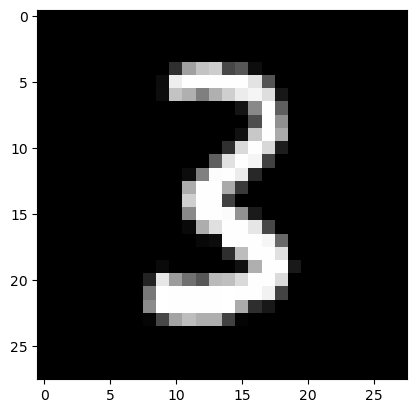

In [73]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [74]:
model,opt = get_model()

In [75]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

### Random sampling
We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [76]:
import random

In [77]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n, self.shuffle = len(ds), shuffle
    def __iter__(self): 
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return (iter(res))

In [78]:
from itertools import islice

In [79]:
ss = Sampler(train_ds)

In [80]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [81]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [82]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[46342, 41573, 23564, 14258, 26955]

In [83]:
import fastcore.all as fc

In [84]:
# The BatchSampler does this islice business for us

class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)      

In [85]:
#  Here we get the BatchSampler to loop through slices of four at a time

batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[11800, 43958, 47311, 43949],
 [9186, 32359, 47845, 16003],
 [18055, 26640, 15488, 41254],
 [677, 17211, 163, 4148],
 [23300, 28658, 41797, 42465]]

In [86]:
list(islice(batchs, 5))

[[13933, 30912, 45555, 6955],
 [32117, 22907, 35338, 32119],
 [12561, 34654, 43677, 39840],
 [32557, 29632, 10701, 1764],
 [38932, 30252, 3499, 48723]]

In [87]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [88]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): 
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)
        
# Fastcore library has a function store_attr() that stores all the arguments as attributes to the class, e.g ds as self.ds

In [89]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [90]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

So now DataLoader used to only combine the features and targers into a "dataset", 
then Sampler a list (randomised or not) from which to get the samples for training and validation,
then BatchSampler gives us a bs-sized batch from the Sampler,
and now DataLoader uses the Sampler and BatchSampler to prepare our dataset for iteration over in the training of our model

tensor(3)

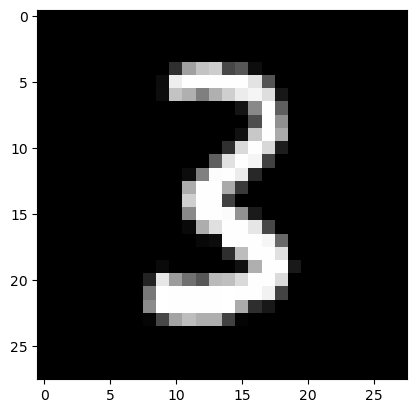

In [91]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

# To prove our DataLoader still has uncorrupted info

In [92]:
xb.shape,yb.shape   
# Tha batches, xb and yb, are the correct sizes

(torch.Size([50, 784]), torch.Size([50]))

In [93]:
model,opt = get_model()

In [94]:
fit()

0.31, 0.90
0.04, 0.98
0.06, 0.96


## Multiprocessing DataLoader

Multiprocessing lets us use the getitem of our DataLoader with several batches in parallel
Python does have a multiprocessing library, but it doesn't work very well with tensors, so Pytorch reimplemented it with the following libraries. 
This is API equivalent

In [95]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [96]:
# Calling [[...]] on a class is equivalent to using getitemt, eg:
# This is important, because we want to use "map"
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [97]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [98]:
# Map lets us use a function over a list of things, like:

for o in map(train_ds.__getitem__, ([3,6], [8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


So now we redefine our DataLoader to make use of this map function, 
then we can use the multiprocessing function "Pool" to pool these batches.
The first iteration will run slower, but once the process is fired up, the whole process will run fasters as everyting is optimised to run in parallel.

N_workers specifies how many of these processes will then run in parallel

In [99]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))
     


In [100]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)   

In [101]:
xb,yb = next(it)
xb.shape,yb.shape    

# This code took very long to excute and I don't know why


(torch.Size([50, 784]), torch.Size([50]))

## Pytorch Dataloader

Pytorch has a lot more code for this process to make it a lot more efficient.

Pytorch doesn't use one sampler with random True/False, like we did, but uses two different samplers, 
Seqential and Random

In [102]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [103]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)    

In [104]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [105]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.10, 0.94
0.10, 0.96
0.27, 0.98


(tensor(0.12, grad_fn=<NllLossBackward0>), tensor(0.96))

This code works just like the code we implemented. Pytorch can also auto-generate the BatchSampler for us, so we don't have to define the samplers first:

In [106]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [107]:
# Pytorch can also completely automate the sequential and random samplers, as most models use these, 
# we can just specify whether we want the data shuffled True/False

train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)
     


In [108]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)    

0.21, 0.92
0.15, 0.94
0.05, 0.98


(tensor(0.13, grad_fn=<NllLossBackward0>), tensor(0.98))

In [109]:
# Because our dataset already knows how to sample a batch of indices at once:

train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

In [110]:
# We can skip the the batch sampler and collate function entirely

train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [111]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation 

Now we want to test the data on the validation set, rather than the test set, so we van actually know how accurate our model is.



You always should also have a validation set, in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)


In [112]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [113]:
# Our simplified get_dls function, we can double the batch size for the validation set as we don't calculate the gradients on those

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [114]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [115]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.14236384611576797 0.958100004196167
1 0.12564025789499284 0.9632000041007995
2 0.1306914868950844 0.9645000052452087
3 0.10988455526065082 0.9670000064373017
4 0.11636362857650966 0.9678000068664551
CPU times: user 25 s, sys: 33.7 s, total: 58.7 s
Wall time: 7.33 s
